In [ ]:
# ============================
# XL_Gate.ipynb — Setup
# Defines: xl_H0, xl_Gstack, xl_uscale_MHz, xl_dt_ns, xl_theta, xl_Nmax, ops, plus a namespace `xl`
# Conventions: H in MHz, dt in ns
# ============================

import jax
import jax.numpy as jnp
import numpy as np
from types import SimpleNamespace

jax.config.update("jax_enable_x64", True)

# MHz*ns -> rad conversion
OMEGA_FAC = 2.0 * jnp.pi * 1e-3

# ----------------- Operators / Hamiltonian -----------------
def annihilation(Nc: int) -> jnp.ndarray:
    data = jnp.sqrt(jnp.arange(1, Nc, dtype=jnp.float64))
    return jnp.diag(data, 1).astype(jnp.complex128)

def kron(A, B):
    return jnp.kron(A, B)

def make_ops(Nmax: int):
    Nc = Nmax + 1
    Iq = jnp.eye(2, dtype=jnp.complex128)
    Ic = jnp.eye(Nc, dtype=jnp.complex128)

    sigx = jnp.array([[0., 1.],[1., 0.]], dtype=jnp.complex128)
    sigy = jnp.array([[0.,-1j],[1j, 0.]], dtype=jnp.complex128)
    sigz = jnp.array([[1., 0.],[0.,-1.]], dtype=jnp.complex128)

    a    = annihilation(Nc)
    adag = a.conj().T
    n    = adag @ a

    X = kron(sigx, Ic)
    Y = kron(sigy, Ic)
    Z = kron(sigz, Ic)

    A    = kron(Iq, a)
    Adag = kron(Iq, adag)
    Nop  = kron(Iq, n)

    I = jnp.eye(2 * Nc, dtype=jnp.complex128)
    return dict(I=I, X=X, Y=Y, Z=Z, A=A, Adag=Adag, N=Nop)

def build_hamiltonian_ops(ops, wc_MHz: float, wq_MHz: float, chi_MHz: float):
    # Dispersive-style H0 in MHz
    H0 = (wc_MHz * ops["N"] +
          0.5   * wq_MHz * ops["Z"] +
          chi_MHz * (ops["N"] @ ops["Z"])).astype(jnp.complex128)

    # Controls: cavity I/Q ~ (a+a†), i(a†-a); qubit X/Y
    Glist = [
        (ops["A"] + ops["Adag"]),
        (1j * (ops["Adag"] - ops["A"])),
        ops["X"],
        ops["Y"],
    ]
    Gstack = jnp.stack(Glist, axis=0).astype(jnp.complex128)
    return H0, Gstack

# ----------------- Problem setup -----------------
xl = SimpleNamespace()

xl_Nmax = 14
ops = make_ops(xl_Nmax)

# Starting w_c, w_q, chi values
wc_MHz  = 5.0
wq_MHz  = 5.0
chi_MHz = -2.0

xl_H0, xl_Gstack = build_hamiltonian_ops(ops, wc_MHz, wq_MHz, chi_MHz)

# Control scales (MHz per unit control)
xl_uscale_MHz = jnp.array([1.5, 1.5, 7.0, 7.0], dtype=jnp.float64)

# Time step in ns
xl_dt_ns = 5.0

# "dt" to use inside expm(-i * H * dt): dimensionless phase per MHz-step
xl_theta = float(OMEGA_FAC * xl_dt_ns)

print("Setup complete:")
print(f"  Nmax={xl_Nmax}, dim={xl_H0.shape[0]}, K={xl_Gstack.shape[0]}")
print(f"  dt_ns={xl_dt_ns}, theta=OMEGA_FAC*dt_ns={xl_theta:.6e}")

Setup complete:
  Nmax=14, dim=30, K=4
  dt_ns=5.0, theta=OMEGA_FAC*dt_ns=3.141593e-02


In [ ]:
# ============================
# X_L via GEOPE (multi-state) on {|g,0>, |g,1>}
# Conventions: H in MHz, dt in ns
# Results are stored in `xl` (SimpleNamespace): xl.phi_X, xl.hist_X, xl.L, xl.dt_ns, xl.T_ns, ...
# ============================

import jax
import jax.numpy as jnp
import numpy as np
from types import SimpleNamespace
from jax import jit, jacfwd

jax.config.update("jax_enable_x64", True)

# ---- pull from XL locals ----
H0         = jnp.array(xl_H0)
Gstack     = jnp.array(xl_Gstack)          # (K, dim, dim)
uscale_MHz = jnp.array(xl_uscale_MHz)      # (K,)
dt_ns      = float(xl_dt_ns)

K   = int(Gstack.shape[0])
dim = int(H0.shape[0])

# phase-step factor (dimensionless)
theta = float(OMEGA_FAC * dt_ns)

# ---- choose gate duration: T = 2/|chi|, set it here manually ----
try:
    chi_MHz = float(chi_MHz)  # from your setup cell, if present
except NameError:
    chi_MHz = -2.0

T_ns   = 2000.0 / abs(chi_MHz)                 # since 1 MHz = 1/μs
L_gate = max(1, int(np.rint(T_ns / dt_ns)))    # nearest integer number of steps
T_ns   = L_gate * dt_ns                         # snap to grid for bookkeeping

print(f"[X_L] Using chi_MHz={chi_MHz:.6g} → T≈2/|chi| = {T_ns:.3f} ns, L={L_gate}, dt={dt_ns:.6f} ns")

# ---------- utilities ----------
def xl_clip_controls(phi, max_abs=1.0):
    return jnp.clip(phi, -max_abs, max_abs)

@jit
def xl_forward_states(phi: jnp.ndarray,
                      Psi0: jnp.ndarray,      # (N,S)
                      H0: jnp.ndarray,
                      Gstack: jnp.ndarray,    # (K,N,N)
                      theta: float,
                      uscale: jnp.ndarray) -> jnp.ndarray:
    """Multi-state forward: propagate S columns together. Returns (N,S)."""
    def step(Psi, pl):
        Hl = H0 + jnp.tensordot(pl * uscale, Gstack, axes=(0, 0))
        U  = jax.scipy.linalg.expm((-1j * theta * Hl).astype(jnp.complex128))
        return U @ Psi, None
    PsiT, _ = jax.lax.scan(step, Psi0, phi)
    return PsiT

def xl_hilbert_geo_direction_single(psi: jnp.ndarray, psitarg: jnp.ndarray) -> jnp.ndarray:
    proj = psi * jnp.vdot(psi, psitarg)
    y = psitarg - proj
    nrm = jnp.linalg.norm(y)
    return jnp.where(nrm > 0, y / nrm, jnp.zeros_like(y))

def xl_J_states(phi, Psi0, H0, Gstack, theta, uscale):
    """Jacobian of flattened PsiT wrt flattened phi. Returns (N*S, P)."""
    L, K = phi.shape
    N, S = Psi0.shape
    def f_flat(p):
        ph = p.reshape((L, K))
        PsiT = xl_forward_states(ph, Psi0, H0, Gstack, theta, uscale)  # (N,S)
        return PsiT.reshape(N * S)
    return jacfwd(f_flat)(phi.ravel())

def xl_average_state_fidelity(Psi, Psitarg):
    amps = jnp.sum(Psitarg.conj() * Psi, axis=0)
    return jnp.real(jnp.mean(amps.conj() * amps))

# ---------- GEOPE step (multi-state) ----------
def xl_geope_gate_step(phi, Psi0, Psitarg,
                       H0, Gstack, theta, uscale,
                       eta_max=0.5, ls_iters=12, resid_gain=0.9, tikh=1e-8, clip_max=1.0):
    L, K = phi.shape
    N, S = Psi0.shape
    P = L * K

    Psi = xl_forward_states(phi, Psi0, H0, Gstack, theta, uscale)  # (N,S)
    Ys = [xl_hilbert_geo_direction_single(Psi[:, s], Psitarg[:, s]) for s in range(S)]
    y  = jnp.stack(Ys, axis=1).reshape(N * S)

    # Jacobian (N*S, P)
    Jmat = xl_J_states(phi, Psi0, H0, Gstack, theta, uscale)

    # Real-augmented LS: A δ = b
    A = jnp.concatenate([jnp.real(Jmat), jnp.imag(Jmat)], axis=0).astype(jnp.float64)  # (2NS, P)
    b = jnp.concatenate([jnp.real(y),    jnp.imag(y)],    axis=0).astype(jnp.float64)  # (2NS,)

    ATA   = A.T @ A + tikh * jnp.eye(P, dtype=A.dtype)
    ATb   = A.T @ b
    delta = jnp.linalg.solve(ATA, ATb).reshape((L, K))
    dflat = delta.ravel()

    f0 = xl_average_state_fidelity(Psi, Psitarg)
    r0 = jnp.linalg.norm(-b)

    eta = jnp.array(eta_max, dtype=jnp.float64)
    best_eta, best_f, best_r = 0.0, f0, r0

    for _ in range(ls_iters):
        cand  = xl_clip_controls(phi + eta * delta, clip_max)
        Psi_c = xl_forward_states(cand, Psi0, H0, Gstack, theta, uscale)
        f1    = xl_average_state_fidelity(Psi_c, Psitarg)
        r1    = jnp.linalg.norm(A @ (eta * dflat) - b)  # linearized residual

        accept = (r1 < resid_gain * best_r) or (f1 > best_f)
        if accept:
            best_eta, best_f, best_r = float(eta), float(f1), float(r1)

        eta = eta / 2.0

    phi_new  = xl_clip_controls(phi + best_eta * delta, clip_max) if (best_eta > 0.0) else phi
    improved = (best_eta > 0.0)
    return phi_new, improved, best_f

def xl_gram_schmidt_escape(phi, scale=0.2, key=jax.random.PRNGKey(0), clip_max=1.0):
    rnd = jax.random.normal(key, phi.shape, dtype=phi.dtype)
    return xl_clip_controls(phi + scale * rnd, clip_max)

def xl_run_geope_gate(phi0, Psi0, Psitarg, H0, Gstack, theta, uscale,
                      iters=600, eta_max=0.6, tol=1e-6, resid_gain=0.95, tikh=1e-7, clip_max=1.0):
    phi = phi0
    history = []
    key = jax.random.PRNGKey(4242)
    for _ in range(iters):
        phi_new, ok, f1 = xl_geope_gate_step(phi, Psi0, Psitarg, H0, Gstack, theta, uscale,
                                             eta_max=eta_max, resid_gain=resid_gain, tikh=tikh, clip_max=clip_max)
        if ok:
            phi = phi_new
        else:
            key, sub = jax.random.split(key)
            phi = xl_gram_schmidt_escape(phi, scale=0.2, key=sub, clip_max=clip_max)

        history.append(f1)
        if f1 > 1 - tol:
            break
    return phi, jnp.array(history, dtype=jnp.float64)

# ---------- logical basis, targets on {|g,0>,|g,1>} ----------
Nc = dim // 2

g  = jnp.array([1., 0.], dtype=jnp.float64)
c0 = jnp.eye(Nc, dtype=jnp.float64)[0]
c1 = jnp.eye(Nc, dtype=jnp.float64)[1]

psi0L = jnp.kron(g.astype(jnp.complex128), c0.astype(jnp.complex128))  # |g,0>
psi1L = jnp.kron(g.astype(jnp.complex128), c1.astype(jnp.complex128))  # |g,1>

Psi0    = jnp.stack([psi0L, psi1L], axis=1)  # (N,2)
Psitarg = jnp.stack([psi1L, psi0L], axis=1)  # swap = X_L

# ---------- initialize + run ----------
key0 = jax.random.PRNGKey(7)
phi0X = 0.05 * jax.random.normal(key0, (L_gate, K), dtype=jnp.float64)

phi_X, hist_X = xl_run_geope_gate(phi0X, Psi0, Psitarg, H0, Gstack, theta, uscale_MHz,
                                  iters=800, eta_max=0.6, tol=1e-6, resid_gain=0.95, tikh=1e-7, clip_max=1.0)

# ---------- report ----------
Psi_final = xl_forward_states(phi_X, Psi0, H0, Gstack, theta, uscale_MHz)
F_avg = float(xl_average_state_fidelity(Psi_final, Psitarg))

amp_0to1 = jnp.vdot(psi1L, Psi_final[:, 0]); amp_1to0 = jnp.vdot(psi0L, Psi_final[:, 1])
amp_0to0 = jnp.vdot(psi0L, Psi_final[:, 0]); amp_1to1 = jnp.vdot(psi1L, Psi_final[:, 1])

print("Average column fidelity (X_L):", F_avg)
print("<1L|U|0L> =", complex(amp_0to1), "  |.|^2 =", float(jnp.abs(amp_0to1)**2))
print("<0L|U|1L> =", complex(amp_1to0), "  |.|^2 =", float(jnp.abs(amp_1to0)**2))
print("<0L|U|0L> =", complex(amp_0to0), "  |.|^2 =", float(jnp.abs(amp_0to0)**2))
print("<1L|U|1L> =", complex(amp_1to1), "  |.|^2 =", float(jnp.abs(amp_1to1)**2))

# ---------- store results in a namespaced object ----------
xl = SimpleNamespace(
    chi_MHz   = chi_MHz,
    T_ns      = T_ns,
    L         = L_gate,
    dt_ns     = dt_ns,
    theta     = theta,
    phi_X     = phi_X,
    hist_X    = hist_X,
    Psi0      = Psi0,
    Psitarg   = Psitarg,
    Psi_final = Psi_final,
    amps      = dict(a01=amp_0to1, a10=amp_1to0, a00=amp_0to0, a11=amp_1to1),
)

print("→ X_L GEOPE stored in `xl` (xl.phi_X, xl.hist_X, xl.T_ns, xl.L, xl.dt_ns, xl.theta, ...)")

[X_L] Using chi_MHz=-2 → T≈2/|chi| = 1000.000 ns, L=200, dt=5.000000 ns
Average column fidelity (X_L): 0.999999061664552
<1L|U|0L> = (0.9968797232753311-0.07893191567701217j)   |.|^2 = 0.9999994299899435
<0L|U|1L> = (0.9937481436490389-0.1116392419055661j)   |.|^2 = 0.9999986933391606
<0L|U|0L> = (-0.0002390511304465031+9.927327488001847e-06j)   |.|^2 = 5.7243994798805086e-08
<1L|U|1L> = (0.0002366393072480927-3.551871979289023e-05j)   |.|^2 = 5.7259741190583086e-08
→ X_L GEOPE stored in `xl` (xl.phi_X, xl.hist_X, xl.T_ns, xl.L, xl.dt_ns, xl.theta, ...)


In [ ]:
# ============================
# Geodesic-ness diagnostics for X_L 
# Also STORES: xl.geodesic["Gamma"], xl.geodesic["U_list"], xl.geodesic["H_list"]
# Conventions: H in MHz, dt in ns, propagator uses expm(-i * (2π*1e-3) * H[MHz] * dt[ns])
# Requires (from prior cells):
# ============================

import jax
import jax.numpy as jnp
import numpy as np
from types import SimpleNamespace

jax.config.update("jax_enable_x64", True)

# ---- X_L locals ----
phi_X      = jnp.array(xl.phi_X)                 # (L, K)
dt_ns      = float(xl.dt_ns)
L_steps    = int(getattr(xl, "L", phi_X.shape[0]))
T_total_ns = float(getattr(xl, "T_ns", L_steps * dt_ns))

H0         = jnp.array(xl_H0)                    # (dim, dim)
Gstack     = jnp.array(xl_Gstack)                # (K, dim, dim)
uscale_MHz = jnp.array(xl_uscale_MHz)            # (K,)

K   = int(Gstack.shape[0])
dim = int(H0.shape[0])

OMEGA_FAC = 2.0 * jnp.pi * 1e-3                  # MHz*ns -> rad
theta     = float(OMEGA_FAC * dt_ns)

assert phi_X.shape[0] == L_steps, "Mismatch: xl.L must equal phi_X.shape[0]"
assert phi_X.shape[1] == K,       "Mismatch: control dimension K differs from xl_Gstack"

# ---- logical target: X_L on {|g,0>,|g,1>} embedded in full space ----
Nc = dim // 2
g  = jnp.array([1., 0.], dtype=jnp.float64)
c0 = jnp.eye(Nc, dtype=jnp.float64)[0]
c1 = jnp.eye(Nc, dtype=jnp.float64)[1]
ket0 = jnp.kron(g.astype(jnp.complex128), c0.astype(jnp.complex128))
ket1 = jnp.kron(g.astype(jnp.complex128), c1.astype(jnp.complex128))

Id   = jnp.eye(dim, dtype=jnp.complex128)
P0   = jnp.outer(ket0, ket0.conj())
P1   = jnp.outer(ket1, ket1.conj())
Plog = P0 + P1

Xlog = jnp.outer(ket0, ket1.conj()) + jnp.outer(ket1, ket0.conj())
V_target = Xlog + (Id - Plog)

def expmH_local(H, th):
    evals, evecs = jnp.linalg.eigh(H)
    phases = jnp.exp(-1j * th * evals)
    return (evecs * phases) @ evecs.conj().T

# ---- rebuild trajectory U_k and H_k ----
U = jnp.eye(dim, dtype=jnp.complex128)
U_list = []
H_list = []
for pl in phi_X:
    Hl = H0 + jnp.tensordot(pl * uscale_MHz, Gstack, axes=(0, 0))
    U  = expmH_local(Hl, theta) @ U
    U_list.append(U)
    H_list.append(Hl)

U_list = jnp.stack(U_list, axis=0)  # (L, dim, dim)
H_list = jnp.stack(H_list, axis=0)  # (L, dim, dim)
U_T    = U_list[-1]

# ---- helpers ----
def fro_inner(A, B): return (jnp.vdot(A.ravel(), B.ravel())).real
def fro_norm(A):     return jnp.sqrt(fro_inner(A, A))

def matrix_log_unitary(W):
    # principal log for unitary via eigen-decomposition (phase unwrapping by angle)
    evals, evecs = jnp.linalg.eig(W)
    angles = jnp.angle(evals)
    Lm = evecs @ jnp.diag(1j * angles) @ jnp.linalg.inv(evecs)
    return 0.5 * (Lm - Lm.conj().T)  # enforce anti-Hermitian

# Γ = log(U_T† V_target) is anti-Hermitian
Gamma = matrix_log_unitary(U_T.conj().T @ V_target)

L_min = float(fro_norm(Gamma))

# Ω_k per unit time: Ω = -i * OMEGA_FAC * H  (since U_step = exp(-i*theta*H), theta=OMEGA_FAC*dt)
# Path length = ∫||Ω|| dt = Σ_k ||Ω_k|| dt = Σ_k (OMEGA_FAC*||H_k||) dt = Σ_k theta ||H_k||
L_path = float(jnp.sum(jax.vmap(fro_norm)(H_list)) * theta)

eta_end = float((L_min / (L_path + 1e-16)).real)

cos_vals = []
num_dev, den_geo = 0.0, 0.0
for U_k, H_k in zip(U_list, H_list):
    Omega     = (-1j * OMEGA_FAC) * H_k
    Omega_geo = (U_k @ Gamma @ U_k.conj().T) / T_total_ns
    nO = float(fro_norm(Omega))
    nG = float(fro_norm(Omega_geo)) + 1e-16
    cos_k = float((fro_inner(Omega, Omega_geo) / (nO * nG + 1e-16)).real)
    cos_vals.append(cos_k)
    num_dev += float(fro_norm(Omega - Omega_geo)) * dt_ns
    den_geo += float(nG) * dt_ns

cos_vals = jnp.array(cos_vals)
cos_mean = float(jnp.mean(cos_vals))
cos_min  = float(jnp.min(cos_vals))
cos_std  = float(jnp.std(cos_vals))
delta_geo = float(num_dev / (den_geo + 1e-16))

print("— Geodesic diagnostics for X_L (local dt/L; no globals) —")
print(f"dt_ns                 : {dt_ns:.6f} ns")
print(f"L_steps               : {L_steps}")
print(f"T_total_ns            : {T_total_ns:.6f} ns")
print(f"theta=OMEGA_FAC*dt     : {theta:.6e}")
print(f"L_min (principal log) : {L_min:.6f}")
print(f"L_path (Σ theta||H||) : {L_path:.6f}")
print(f"η_end = L_min/L_path  : {eta_end:.6f}")
print(f"<cos θ>               : {cos_mean:.6f}   (min {cos_min:.6f}, std {cos_std:.6f})")
print(f"δ_geo (rel. dev.)     : {delta_geo:.6f}")

# ---- store everything needed for the next "projected geodesic pulses" cell ----
if not hasattr(xl, "geodesic") or not isinstance(getattr(xl, "geodesic"), dict):
    xl.geodesic = {}

xl.geodesic.update(dict(
    dt_ns=dt_ns,
    L_steps=L_steps,
    T_total_ns=T_total_ns,
    theta=theta,
    OMEGA_FAC=float(OMEGA_FAC),
    Gamma=Gamma,
    U_list=U_list,
    H_list=H_list,
    L_min=L_min,
    L_path=L_path,
    eta_end=eta_end,
    cos_mean=cos_mean,
    cos_min=cos_min,
    cos_std=cos_std,
    delta_geo=delta_geo,
    cos_series=cos_vals,
))

print("→ Stored: xl.geodesic['Gamma'], ['U_list'], ['H_list'], plus summary stats.")

— Geodesic diagnostics for X_L (local dt/L; no globals) —
dt_ns                 : 5.000000 ns
L_steps               : 200
T_total_ns            : 1000.000000 ns
theta=OMEGA_FAC*dt     : 3.141593e-02
L_min (principal log) : 9.717202
L_path (Σ theta||H||) : 1511.321665
η_end = L_min/L_path  : 0.006430
<cos θ>               : 0.067719   (min 0.032575, std 0.016590)
δ_geo (rel. dev.)     : 155.466015
→ Stored: xl.geodesic['Gamma'], ['U_list'], ['H_list'], plus summary stats.


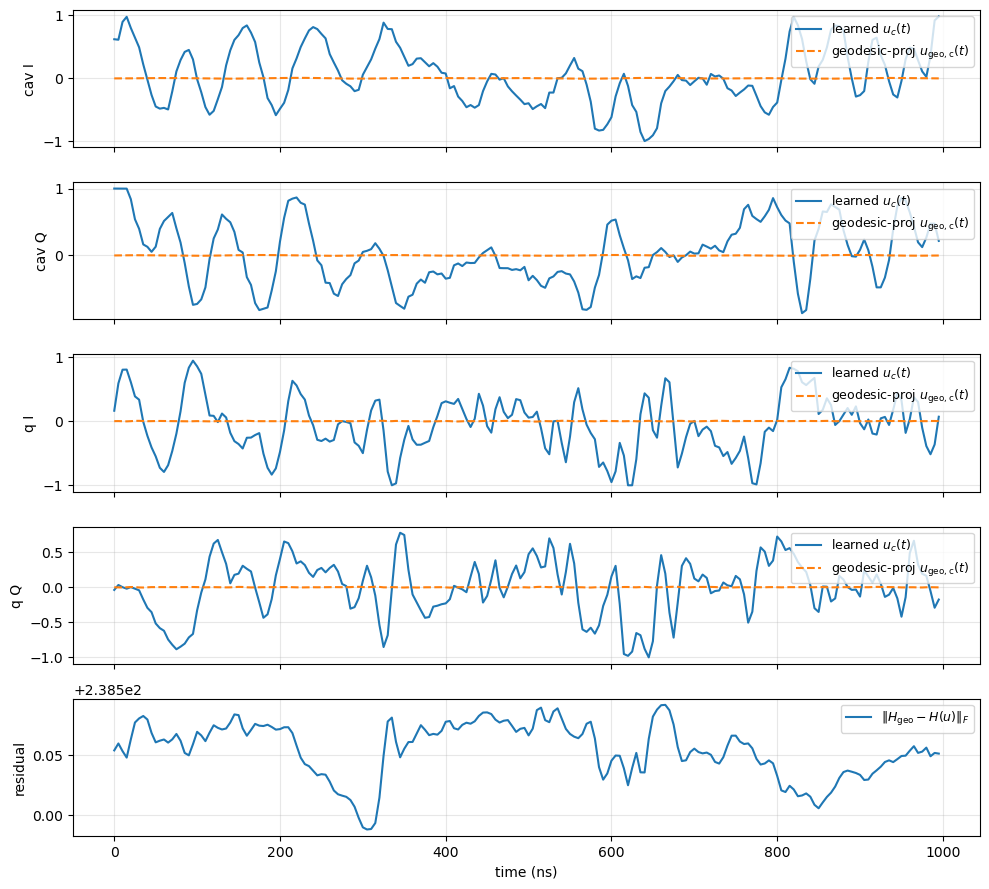

→ Stored: xl.geodesic['u_geo'], xl.geodesic['u_geo_resid']


In [ ]:
# ============================
# Compare learned X_L pulses to projected geodesic pulses
# Produces u_geo[t,c] and plots vs learned controls phi_X[t,c]
# ============================

import numpy as np
import matplotlib.pyplot as plt

# ---- X_L locals ----
phi_X      = np.array(xl.phi_X)                     # (L, K)
dt_ns      = float(xl.dt_ns)
L_steps    = int(getattr(xl, "L", phi_X.shape[0]))

# ---- Hamiltonian pieces ----
H0         = np.array(xl_H0)                        # (dim, dim)
Gstack     = np.array(xl_Gstack)                    # (K, dim, dim)
uscale_MHz = np.array(xl_uscale_MHz)                # (K,)

L, K = phi_X.shape
assert L == L_steps, "Mismatch: xl.L must equal phi_X.shape[0]"

# ---- Geodesic objects ----
if not (hasattr(xl, "geodesic") and isinstance(xl.geodesic, dict)):
    raise RuntimeError("xl.geodesic not found. Run the geodesic-ness cell first.")

Gamma      = np.array(xl.geodesic["Gamma"])
U_list     = np.array(xl.geodesic["U_list"])
T_total_ns = float(xl.geodesic.get("T_total_ns", xl.geodesic.get("T_ns", L_steps * dt_ns)))

OMEGA_FAC  = float(xl.geodesic.get("OMEGA_FAC", 2.0 * np.pi * 1e-3))  # MHz*ns -> rad

dim = H0.shape[0]

# ---- Flatten control operators once for LS projection ----
# We fit: H_geo - H0 ≈ Σ_c s_c * G_c, where s_c = u_c * uscale_c
A = np.stack([Gstack[c].reshape(-1) for c in range(K)], axis=1)   # (dim^2, K)
AH_A = A.conj().T @ A
A_pinv = np.linalg.pinv(AH_A, rcond=1e-12) @ A.conj().T           # (K, dim^2)

u_geo = np.zeros((L_steps, K), dtype=np.float64)
resid = np.zeros(L_steps, dtype=np.float64)

for t in range(L_steps):
    U = U_list[t]

    # Ω_geo(t) per unit time, then H_geo(t) in MHz:
    # Ω_geo = U Γ U† / T, and Ω = -i*OMEGA_FAC*H  =>  H = (i/OMEGA_FAC) Ω
    Omega_geo = U @ Gamma @ U.conj().T / T_total_ns
    H_geo = (1j / OMEGA_FAC) * Omega_geo
    H_geo = 0.5 * (H_geo + H_geo.conj().T)  # enforce Hermitian numerically

    # Solve for s (scaled coefficients): s = argmin ||A s - vec(H_geo - H0)||
    B = (H_geo - H0).reshape(-1)
    s = A_pinv @ B                           # (K,)

    # unscale: u = s / uscale
    u_hat = s / uscale_MHz[:K]
    u_geo[t, :] = np.real(u_hat)             # imaginary should be ~0 for Hermitian fit

    # residual
    H_fit = H0.copy()
    for c in range(K):
        H_fit += (u_hat[c] * uscale_MHz[c]) * Gstack[c]
    resid[t] = np.linalg.norm((H_geo - H_fit).reshape(-1))

# ---- Plot ----
time_ns = np.arange(L_steps) * dt_ns
labels = [r'cav I', r'cav Q', r'q I', r'q Q'][:K]

fig, axs = plt.subplots(K+1, 1, figsize=(10, 1.8*(K+1)), sharex=True)

for c in range(K):
    axs[c].plot(time_ns, phi_X[:, c], label='learned $u_c(t)$')
    axs[c].plot(time_ns, u_geo[:, c], linestyle='--', label=r'geodesic-proj $u_{\rm geo,c}(t)$')
    axs[c].set_ylabel(labels[c] if c < len(labels) else f'c{c}')
    axs[c].grid(True, alpha=0.3)
    axs[c].legend(loc='upper right', fontsize=9)

axs[K].plot(time_ns, resid, label=r'$\|H_{\rm geo}-H(u)\|_F$')
axs[K].set_ylabel('residual')
axs[K].set_xlabel('time (ns)')
axs[K].grid(True, alpha=0.3)
axs[K].legend(loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()

# ---- stash results ----
xl.geodesic["u_geo"] = u_geo
xl.geodesic["u_geo_resid"] = resid

print("→ Stored: xl.geodesic['u_geo'], xl.geodesic['u_geo_resid']")

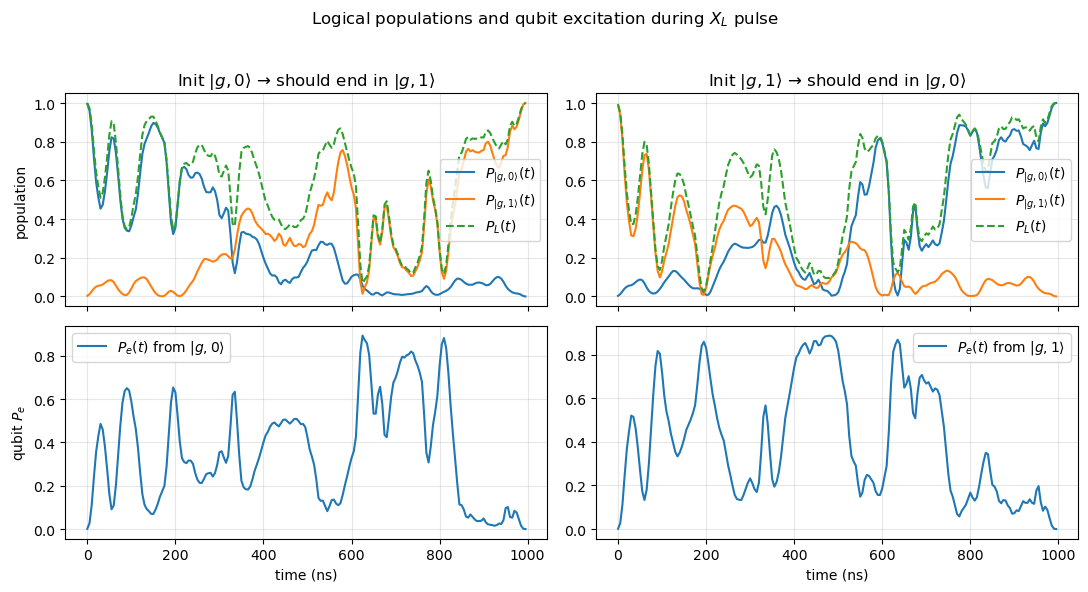

Final populations:
  from |g,0>:  P_g0 = 5.724399479833471e-08  P_g1 = 0.9999994299899444  P_e = 4.6152261162768547e-07  P_L = 0.9999994872339392
  from |g,1>:  P_g0 = 0.9999986933391586  P_g1 = 5.7259741189869825e-08  P_e = 1.163397409139439e-06  P_L = 0.9999987505988998


In [ ]:
# ============================
# Logical population verification for the X_L pulse (phi_X)
# Uses: H [MHz], dt_ns [ns] with OMEGA_FAC = 2π*1e-3 
# ============================

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)

# ---- X_L locals ----
phi_X      = jnp.array(xl.phi_X)                 # (L, K)
dt_ns      = float(xl.dt_ns)

H0         = jnp.array(xl_H0)                    # (dim, dim) in MHz
Gstack     = jnp.array(xl_Gstack)                # (K, dim, dim)
uscale_MHz = jnp.array(xl_uscale_MHz)            # (K,)

K   = int(Gstack.shape[0])
dim = int(H0.shape[0])

# Prefer xl_Nmax if you have it; else infer Nc from dim (=2*(Nmax+1))
try:
    Nmax = int(xl_Nmax)
    Nc = Nmax + 1
except NameError:
    Nc = dim // 2
    Nmax = Nc - 1

OMEGA_FAC = 2.0 * jnp.pi * 1e-3
theta     = float(OMEGA_FAC * dt_ns)

def forward_trajectory(phi, psi0, H0, Gstack, theta, uscale):
    """Return full state trajectory (L, N) under piecewise-const controls phi (L,K)."""
    us = uscale[:Gstack.shape[0]].astype(jnp.float64)

    def step(psi, pl):
        Hl = H0 + jnp.tensordot(pl * us, Gstack, axes=(0, 0))
        # NOTE: theta already includes dt_ns and OMEGA_FAC, so it is dimensionless
        U  = jax.scipy.linalg.expm((-1j * theta * Hl).astype(jnp.complex128))
        psi_next = U @ psi
        return psi_next, psi_next

    _, traj = jax.lax.scan(step, psi0, phi)  # (L, N)
    return traj

# ---- basis states ----
g  = jnp.array([1., 0.], dtype=jnp.float64)
c0 = jnp.eye(Nc, dtype=jnp.float64)[0]
c1 = jnp.eye(Nc, dtype=jnp.float64)[1]
ket_g0 = jnp.kron(g.astype(jnp.complex128), c0.astype(jnp.complex128))
ket_g1 = jnp.kron(g.astype(jnp.complex128), c1.astype(jnp.complex128))

# ---- run both initial states ----
traj0 = np.asarray(forward_trajectory(phi_X, ket_g0, H0, Gstack, theta, uscale_MHz))  # (L,N)
traj1 = np.asarray(forward_trajectory(phi_X, ket_g1, H0, Gstack, theta, uscale_MHz))  # (L,N)

L = traj0.shape[0]
t = np.arange(L) * dt_ns  # ns

# ---- helper overlaps ----
def prob_overlap(traj, ket):
    amp = traj @ np.conjugate(np.asarray(ket))   # (L,)
    return np.real(amp * np.conjugate(amp))

# ---- logical populations ----
P_g0_from0 = prob_overlap(traj0, ket_g0)
P_g1_from0 = prob_overlap(traj0, ket_g1)
P_g0_from1 = prob_overlap(traj1, ket_g0)
P_g1_from1 = prob_overlap(traj1, ket_g1)

# ---- qubit excited population (sum over cavity) for each run ----
# Basis ordering: [|g,n> for n=0..Nmax] then [|e,n> for n=0..Nmax]
Pe_from0 = np.sum(np.abs(traj0[:, Nc:])**2, axis=1)
Pe_from1 = np.sum(np.abs(traj1[:, Nc:])**2, axis=1)

# ---- logical-subspace population (leakage check within {|g,0>,|g,1>} only) ----
PL_from0 = P_g0_from0 + P_g1_from0
PL_from1 = P_g0_from1 + P_g1_from1

# ---- Plots ----
fig, axs = plt.subplots(2, 2, figsize=(11, 6), sharex=True)

axs[0,0].plot(t, P_g0_from0, label=r'$P_{|g,0\rangle}(t)$')
axs[0,0].plot(t, P_g1_from0, label=r'$P_{|g,1\rangle}(t)$')
axs[0,0].plot(t, PL_from0,  '--', label=r'$P_{L}(t)$')
axs[0,0].set_title(r'Init $|g,0\rangle$ → should end in $|g,1\rangle$')
axs[0,0].set_ylabel('population'); axs[0,0].grid(alpha=0.3); axs[0,0].legend()

axs[0,1].plot(t, P_g0_from1, label=r'$P_{|g,0\rangle}(t)$')
axs[0,1].plot(t, P_g1_from1, label=r'$P_{|g,1\rangle}(t)$')
axs[0,1].plot(t, PL_from1,  '--', label=r'$P_{L}(t)$')
axs[0,1].set_title(r'Init $|g,1\rangle$ → should end in $|g,0\rangle$')
axs[0,1].grid(alpha=0.3); axs[0,1].legend()

axs[1,0].plot(t, Pe_from0, label=r'$P_e(t)$ from $|g,0\rangle$')
axs[1,0].set_ylabel(r'qubit $P_e$'); axs[1,0].set_xlabel('time (ns)')
axs[1,0].grid(alpha=0.3); axs[1,0].legend()

axs[1,1].plot(t, Pe_from1, label=r'$P_e(t)$ from $|g,1\rangle$')
axs[1,1].set_xlabel('time (ns)')
axs[1,1].grid(alpha=0.3); axs[1,1].legend()

plt.suptitle(r'Logical populations and qubit excitation during $X_L$ pulse')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print("Final populations:")
print("  from |g,0>:  P_g0 =", P_g0_from0[-1], " P_g1 =", P_g1_from0[-1], " P_e =", Pe_from0[-1], " P_L =", PL_from0[-1])
print("  from |g,1>:  P_g0 =", P_g0_from1[-1], " P_g1 =", P_g1_from1[-1], " P_e =", Pe_from1[-1], " P_L =", PL_from1[-1])

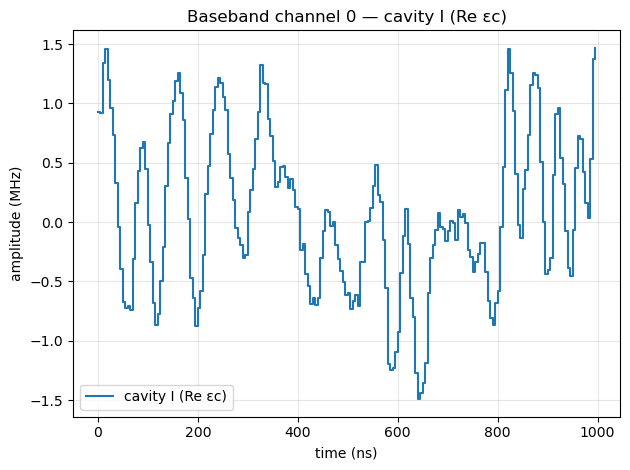

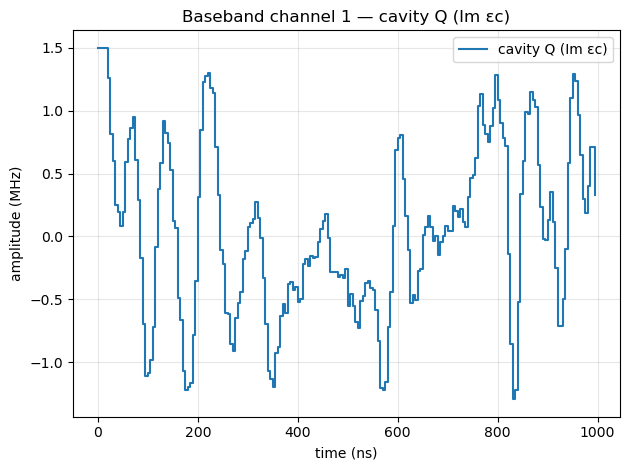

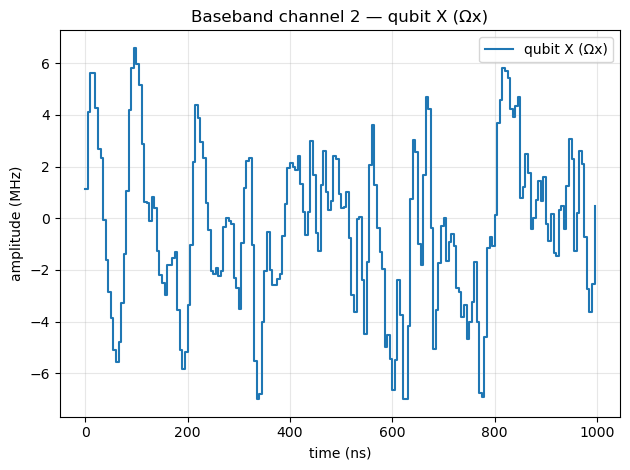

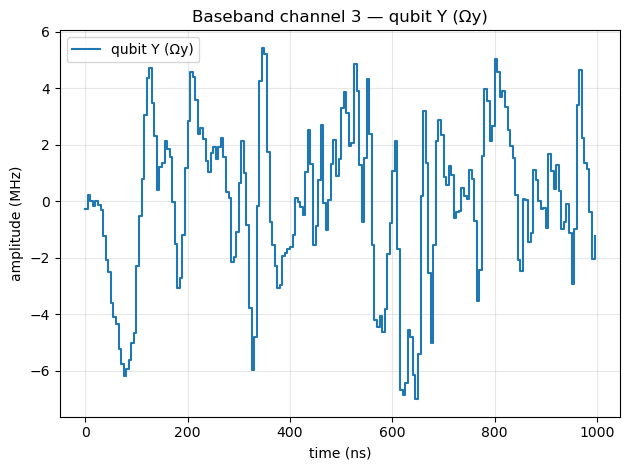

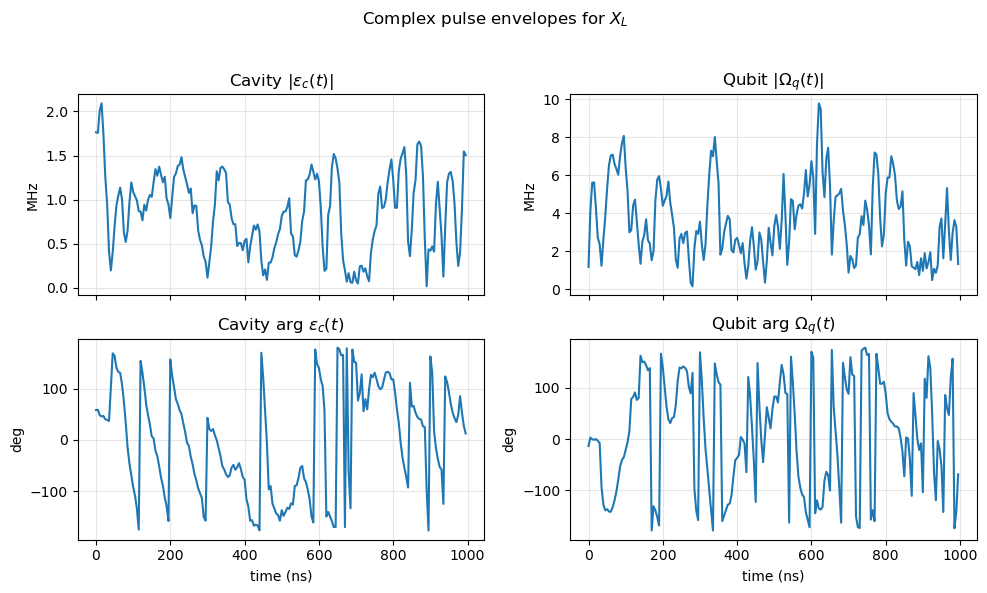

Pulse summary: L=200, dt_ns=5.0, T=1000.000 ns, K=4
Max |u_MHz| per channel: [1.49228465 1.5        7.         7.        ]


In [ ]:
# ============================
# Pulse analysis for X_L: IQ (step) + amplitude/phase
# Uses: xl.phi_X, xl.dt_ns, xl_H0/xl_Gstack, xl_uscale_MHz
# ============================

import numpy as np
import matplotlib.pyplot as plt

# ---- X_L locals ----
phi_X      = np.array(xl.phi_X)                 # (L, K) dimensionless controls
dt_ns      = float(xl.dt_ns)                    # ns
Gstack     = np.array(xl_Gstack)                # (K, dim, dim)
uscale_MHz = np.array(xl_uscale_MHz)            # (K,) MHz per unit control

L, K = phi_X.shape[0], Gstack.shape[0]
assert phi_X.shape[1] == K, "Mismatch: phi_X K must match xl_Gstack K"

t = np.arange(L) * dt_ns  # ns (FIXED)

# Physical amplitudes in MHz (per channel)
u_MHz = phi_X * uscale_MHz[:K][None, :]   # (L, K) in MHz

labels = []
if K >= 1: labels.append("cavity I (Re εc)")
if K >= 2: labels.append("cavity Q (Im εc)")
if K >= 3: labels.append("qubit X (Ωx)")
if K >= 4: labels.append("qubit Y (Ωy)")
for k in range(len(labels), K):
    labels.append(f"channel {k}")

# ---- Step plots per channel ----
for k in range(K):
    plt.figure()
    plt.step(t, u_MHz[:, k], where="post", label=labels[k])
    plt.xlabel("time (ns)")
    plt.ylabel("amplitude (MHz)")
    plt.title(f"Baseband channel {k} — {labels[k]}")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
plt.show()

# ---- Complex envelopes and polar view ----
eps_c = u_MHz[:, 0] + 1j * (u_MHz[:, 1] if K >= 2 else 0.0)
amp_c = np.abs(eps_c)
ph_c  = np.angle(eps_c, deg=True)

Om_q = None
if K >= 3:
    Om_q = u_MHz[:, 2] + 1j * (u_MHz[:, 3] if K >= 4 else 0.0)
    amp_q = np.abs(Om_q)
    ph_q  = np.angle(Om_q, deg=True)

# ---- Plots: amplitude/phase ----
if Om_q is None:
    fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
    axs[0].plot(t, amp_c)
    axs[0].set_ylabel("MHz")
    axs[0].set_title(r"Cavity $|\epsilon_c(t)|$")
    axs[0].grid(alpha=0.3)

    axs[1].plot(t, ph_c)
    axs[1].set_ylabel("deg")
    axs[1].set_xlabel("time (ns)")
    axs[1].set_title(r"Cavity $\arg\,\epsilon_c(t)$")
    axs[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharex=True)

    axs[0, 0].plot(t, amp_c)
    axs[0, 0].set_title(r"Cavity $|\epsilon_c(t)|$")
    axs[0, 0].set_ylabel("MHz")
    axs[0, 0].grid(alpha=0.3)

    axs[1, 0].plot(t, ph_c)
    axs[1, 0].set_title(r"Cavity $\arg\,\epsilon_c(t)$")
    axs[1, 0].set_ylabel("deg")
    axs[1, 0].set_xlabel("time (ns)")
    axs[1, 0].grid(alpha=0.3)

    axs[0, 1].plot(t, amp_q)
    axs[0, 1].set_title(r"Qubit $|\Omega_q(t)|$")
    axs[0, 1].set_ylabel("MHz")
    axs[0, 1].grid(alpha=0.3)

    axs[1, 1].plot(t, ph_q)
    axs[1, 1].set_title(r"Qubit $\arg\,\Omega_q(t)$")
    axs[1, 1].set_ylabel("deg")
    axs[1, 1].set_xlabel("time (ns)")
    axs[1, 1].grid(alpha=0.3)

    plt.suptitle(r"Complex pulse envelopes for $X_L$")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

print(f"Pulse summary: L={L}, dt_ns={dt_ns}, T={L*dt_ns:.3f} ns, K={K}")
print("Max |u_MHz| per channel:", np.max(np.abs(u_MHz), axis=0))